<a href="https://colab.research.google.com/github/Cynthiaudoye/CreditRisk_NN/blob/main/CreditRisk_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up libraries**

In [19]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import random
import tensorflow as tf
import seaborn as sns


## **Loading and exploring the data**

In [20]:
# Fetching the dataset from OpenML
data = fetch_openml(name="credit-g", version=1, as_frame=True)
df = data.frame
df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
5,no checking,36,existing paid,education,9055,no known savings,1<=X<4,2,male single,none,...,no known property,35,none,for free,1,unskilled resident,2,yes,yes,good
6,no checking,24,existing paid,furniture/equipment,2835,500<=X<1000,>=7,3,male single,none,...,life insurance,53,none,own,1,skilled,1,none,yes,good
7,0<=X<200,36,existing paid,used car,6948,<100,1<=X<4,2,male single,none,...,car,35,none,rent,1,high qualif/self emp/mgmt,1,yes,yes,good
8,no checking,12,existing paid,radio/tv,3059,>=1000,4<=X<7,2,male div/sep,none,...,real estate,61,none,own,1,unskilled resident,1,none,yes,good
9,0<=X<200,30,critical/other existing credit,new car,5234,<100,unemployed,4,male mar/wid,none,...,car,28,none,own,2,high qualif/self emp/mgmt,1,none,yes,bad


In [21]:
# Generating the overview of the dataset
print(df.shape)
df.info()

(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing       

In [22]:
# Understanding the distribution of the categorical data in the class column
df['class'].value_counts()

,count
class,
good,700
bad,300


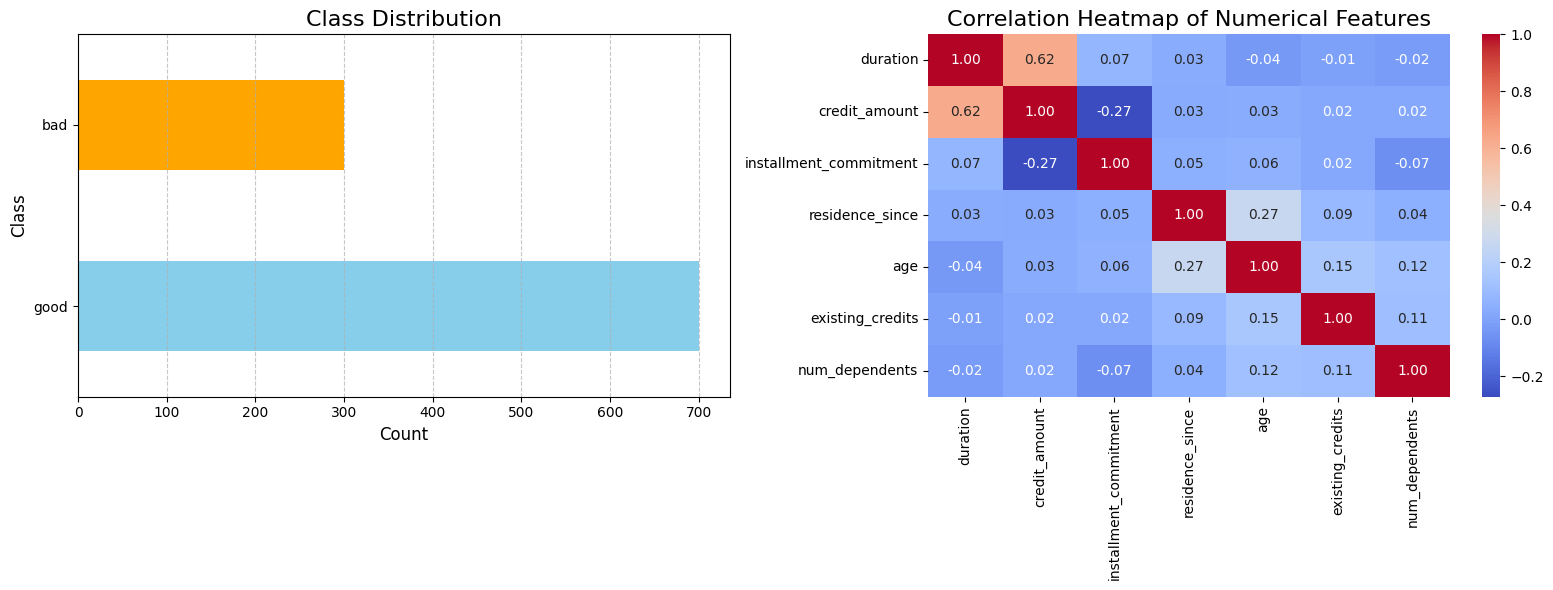

In [23]:
# Creating a horizontal layout for both plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# 1. Class Distribution Horizontal Bar Chart
df['class'].value_counts().plot(kind='barh', color=['skyblue', 'orange'], ax=axes[0])
axes[0].set_title("Class Distribution", fontsize=16)
axes[0].set_xlabel("Count", fontsize=12)  # Adjust axis labels
axes[0].set_ylabel("Class", fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# 2. Correlation Heatmap for Numerical Features
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_df = df[num_columns]  # Subset of numerical features
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=axes[1])
axes[1].set_title("Correlation Heatmap of Numerical Features", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


In [24]:
# Setting random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# **Data Preprocessing**

In [25]:
# Selecting features and label
X = df.drop(columns=['class'])
y = df['class']

# Encoding our target varaible
y = y.apply(lambda x: 1 if x == 'bad' else 0)

# Identifying categorical and numerical columns
cat_columns = X.select_dtypes(include = ['object', 'category']).columns.tolist()
num_columns = X.select_dtypes(include = ['int64', 'float']).columns.tolist()

print('Categorical Columnn:', cat_columns)
print('Numerical Columns:', num_columns)

Categorical Columnn: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numerical Columns: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


In [26]:
# Preprocessing both numerical and catigorical
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

# Creating a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ]
)

# Preprocess data using a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_preprocessed = pipeline.fit_transform(X)

# Convert X_preprocessed to a dense NumPy array
X_preprocessed = np.array(X_preprocessed)

# Debug: Check final feature count and transformations
print("Type of X_preprocessed:", type(X_preprocessed))
print("Final feature count after preprocessing:", X_preprocessed.shape[1])

Type of X_preprocessed: <class 'numpy.ndarray'>
Final feature count after preprocessing: 61


In [27]:
# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

# Further split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (600, 61)
Validation set size: (200, 61)
Test set size: (200, 61)


# **Handling imbalance in data**

In [28]:
# Calculating the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7142857142857143, 1: 1.6666666666666667}


In [29]:
# Ensure correct data types and shapes
X_train = np.array(X_train).astype(np.float32)
X_val = np.array(X_val).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)

# Verify class weights
print("Class Weights:", class_weights_dict)
print("Unique classes in y_train:", np.unique(y_train))

Class Weights: {0: 0.7142857142857143, 1: 1.6666666666666667}
Unique classes in y_train: [0. 1.]


# **Building the Multi-Layer Perceptron model**

In [30]:
# Function to build the MLP model with Dropout and L2 regularization
def build_mlp(input_dim, output_dim, hidden_layers=2, units_per_layer=64, l2_lambda=0.01, dropout_rate=0.4):
    """
    Build a Multi-Layer Perceptron (MLP) model with Dropout and L2 regularization.

    Args:
        input_dim (int): Number of input features.
        output_dim (int): Number of output units (1 for binary classification).
        hidden_layers (int): Number of hidden layers in the network.
        units_per_layer (int): Number of neurons in each hidden layer.
        l2_lambda (float): L2 regularization parameter to reduce overfitting.
        dropout_rate (float): Dropout rate for regularization to prevent overfitting.

    Returns:
        model (Sequential): Compiled Keras MLP model.
    """
    model = Sequential()

    # Input layer: Specifies the shape of the input data
    model.add(Input(shape=(input_dim,)))  # Explicit input shape for clarity

    # Add hidden layers
    for i in range(hidden_layers):
        # Dense layer with L2 regularization to penalize large weights
        model.add(Dense(units_per_layer, activation='relu', kernel_regularizer=l2(l2_lambda)))
        # Dropout to randomly deactivate neurons during training for regularization
        model.add(Dropout(dropout_rate))

    # Output layer: Sigmoid activation for binary classification (0 or 1 output)
    model.add(Dense(output_dim, activation='sigmoid'))

    # Compile the model using Adam optimizer (adaptive learning rate)
    # Binary cross-entropy is suitable for binary classification tasks
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# **Creating function to train and evalute with class weights**

In [31]:
# Function to train and evaluate the model
def train_and_evaluate_with_class_weights(
    X_train, y_train, X_val, y_val, X_test, y_test,
    depth, width, epochs=50, batch_size=32
):
    """
    Train and evaluate an MLP model with precomputed class weights.

    Args:
        X_train, y_train: Training data and corresponding labels.
        X_val, y_val: Validation data and labels for early stopping.
        X_test, y_test: Test data and labels for evaluation.
        depth (int): Number of hidden layers.
        width (int): Number of neurons per layer.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for model training.

    Returns:
        history: Training history object.
        auc_score (float): AUC-ROC score on the test set.
        classification_metrics (dict): Classification metrics such as precision, recall, etc.
    """
    print(f"Training MLP: Depth={depth}, Width={width}...")

    # Build the MLP model with the specified architecture
    model = build_mlp(input_dim=X_train.shape[1], output_dim=1, hidden_layers=depth, units_per_layer=width)

    # Early stopping to prevent overfitting if validation loss stops improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model using class weights to handle imbalanced datasets
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        class_weight=class_weights_dict,  # Address class imbalance using computed weights
        verbose=1
    )

    # Evaluate the model on the test set
    y_pred_proba = model.predict(X_test, batch_size=batch_size)  # Predicted probabilities
    y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate performance metrics
    classification_metrics = classification_report(y_test, y_pred, output_dict=True)  # Detailed metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)  # AUC-ROC measures classifier performance

    return history, auc_score, classification_metrics


# **Creating function to loop for the experiment**

In [32]:
# Experimentation loop to test various depths and widths
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test, depths, widths, epochs=50, batch_size=32):
    """
    Run experiments with varying depths and widths for the MLP.

    Args:
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        X_test, y_test: Test data and labels.
        depths (list): List of hidden layer depths to test.
        widths (list): List of neuron counts per layer to test.

    Returns:
        results (list): Experiment results containing performance metrics.
    """
    results = []  # To store results for each combination of depth and width

    for depth in depths:
        for width in widths:
            try:
                # Train and evaluate the model
                history, auc, metrics = train_and_evaluate_with_class_weights(
                    X_train, y_train, X_val, y_val, X_test, y_test,
                    depth=depth, width=width, epochs=epochs, batch_size=batch_size
                )

                # Store relevant metrics in a dictionary
                results.append({
                    'Depth': depth,
                    'Width': width,
                    'Optimizer': 'adam',
                    'Epochs': len(history.history['loss']),  # Total epochs used
                    'Training Accuracy': history.history['accuracy'][-1],
                    'Validation Accuracy': history.history['val_accuracy'][-1],
                    'Training Loss': history.history['loss'][-1],
                    'Validation Loss': history.history['val_loss'][-1],
                    'Final AUC-ROC': auc,
                    'Precision (0)': metrics['0']['precision'],
                    'Recall (0)': metrics['0']['recall'],
                    'F1-Score (0)': metrics['0']['f1-score'],
                    'Precision (1)': metrics['1']['precision'],
                    'Recall (1)': metrics['1']['recall'],
                    'F1-Score (1)': metrics['1']['f1-score'],
                    'Overall Accuracy': metrics['accuracy']
                })

                print(f"Completed: Depth={depth}, Width={width}, AUC-ROC={auc:.4f}")

            except Exception as e:
                # Handle errors during training for specific configurations
                print(f"Error with Depth={depth}, Width={width}: {e}")

    return results  # Return the experiment results

# **Running experiment**

In [33]:
# Running experiments with multiple depths and widths
depths = [2, 3, 4]  # Number of hidden layers to test
widths = [32, 64, 96, 128, 256]  # Number of neurons per layer

# Run experiments and store results
results_with_class_weights = run_experiments(X_train, y_train, X_val, y_val, X_test, y_test, depths, widths)

# Convert results to a DataFrame for easy visualization
results_df_with_weights = pd.DataFrame(results_with_class_weights)

# Display the results DataFrame
results_df_with_weights

Training MLP: Depth=2, Width=32...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5485 - loss: 1.4144 - val_accuracy: 0.5600 - val_loss: 1.3332
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5484 - loss: 1.3423 - val_accuracy: 0.6550 - val_loss: 1.2490
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6031 - loss: 1.2419 - val_accuracy: 0.6850 - val_loss: 1.1775
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6500 - loss: 1.1690 - val_accuracy: 0.6950 - val_loss: 1.1157
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 1.1438 - val_accuracy: 0.6700 - val_loss: 1.0749
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6995 - loss: 1.0462 - val_accuracy: 0.6700 - val_loss: 1.0325
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6705 - loss: 1.0053 - val_accuracy: 0.6600 - val_loss: 0.9878
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7185 - loss: 0.958

,Depth,Width,Optimizer,Epochs,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Final AUC-ROC,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),Overall Accuracy
0,2,32,adam,50,0.806667,0.610,0.522751,0.709341,0.793810,0.868421,0.707143,0.779528,0.523256,0.750000,0.616438,0.720
1,2,64,adam,50,0.838333,0.650,0.474045,0.740406,0.792619,0.853448,0.707143,0.773438,0.511905,0.716667,0.597222,0.710
2,2,96,adam,41,0.853333,0.625,0.466832,0.778693,0.803333,0.859504,0.742857,0.796935,0.544304,0.716667,0.618705,0.735
3,2,128,adam,41,0.875000,0.655,0.460502,0.771611,0.781667,0.841667,0.721429,0.776923,0.512500,0.683333,0.585714,0.710
4,2,256,adam,36,0.885000,0.655,0.443330,0.830410,0.790119,0.866071,0.692857,0.769841,0.511364,0.750000,0.608108,0.710
5,3,32,adam,50,0.831667,0.620,0.526868,0.741665,0.802143,0.854701,0.714286,0.778210,0.518072,0.716667,0.601399,0.715
6,3,64,adam,36,0.803333,0.610,0.538039,0.777615,0.793929,0.870690,0.721429,0.789062,0.535714,0.750000,0.625000,0.730
7,3,96,adam,36,0.830000,0.635,0.512734,0.807776,0.792381,0.881818,0.692857,0.776000,0.522222,0.783333,0.626667,0.720
8,3,128,adam,34,0.861667,0.665,0.486148,0.812311,0.784286,0.853448,0.707143,0.773438,0.511905,0.716667,0.597222,0.710
9,3,256,adam,35,0.906667,0.680,0.460751,0.896575,0.783929,0.844262,0.735714,0.786260,0.525641,0.683333,0.594203,0.720


# **Visualising model performance**

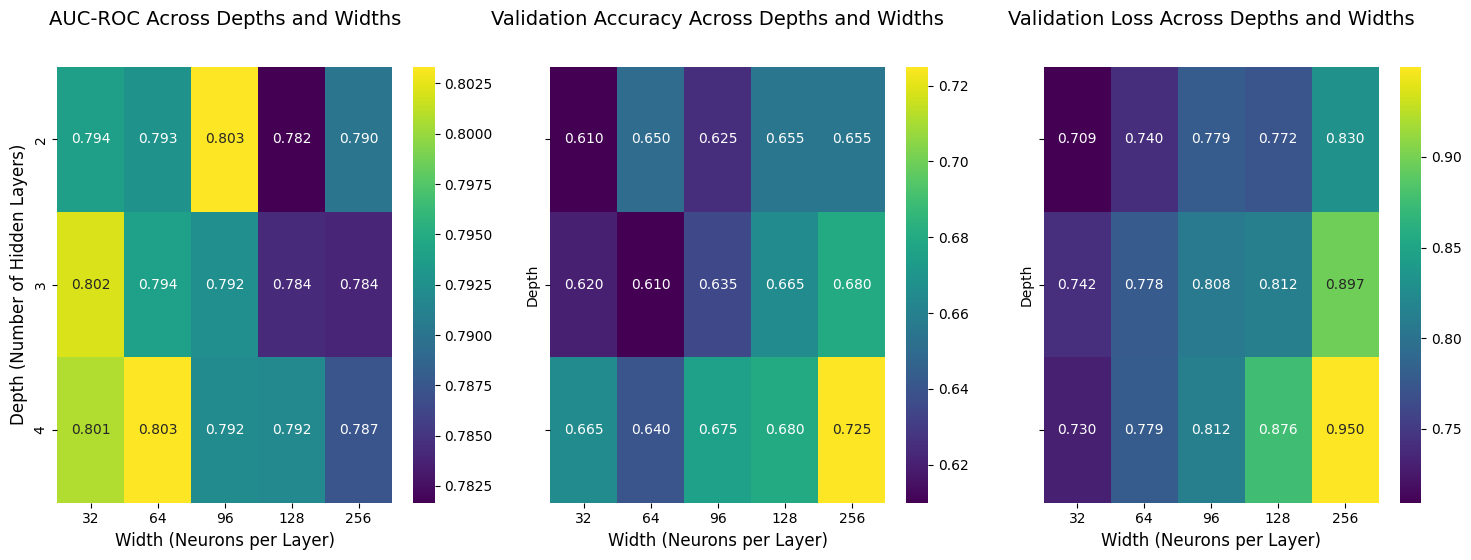

In [34]:
# Function to visualize trends in model performance
def plot_performance_trends_horizontal_with_title_spacing(results_df, metrics, titles):
    """
    Plot trends in model performance across depths and widths in a horizontal arrangement,
    with additional space between titles.

    Args:
        results_df (DataFrame): DataFrame containing experiment results.
        metrics (list): List of metrics to visualize (e.g., ['Final AUC-ROC', 'Validation Accuracy']).
        titles (list): List of titles for each subplot.
    """
    # Set up the subplot layout
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 6), sharey=True)

    for i, metric in enumerate(metrics):
        pivot_df = results_df.pivot(index='Depth', columns='Width', values=metric)
        sns.heatmap(
            pivot_df, annot=True, fmt=".3f", cmap='viridis', cbar=True, ax=axes[i]
        )
        axes[i].set_title(titles[i], fontsize=14, pad=30)  # Increased padding for spacing
        axes[i].set_xlabel("Width (Neurons per Layer)", fontsize=12)
        if i == 0:
            axes[i].set_ylabel("Depth (Number of Hidden Layers)", fontsize=12)

    # Adjust subplot spacing to add space between plots and titles
    plt.subplots_adjust(wspace=0.4)  # Increasing horizontal spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Keeping the overall layout tight but with room for spacing
    plt.show()

# Metrics and titles to visualize
metrics = ['Final AUC-ROC', 'Validation Accuracy', 'Validation Loss']
titles = [
    "AUC-ROC Across Depths and Widths",
    "Validation Accuracy Across Depths and Widths",
    "Validation Loss Across Depths and Widths",
]

# Visualize the metrics with adjusted title spacing
plot_performance_trends_horizontal_with_title_spacing(results_df_with_weights, metrics, titles)


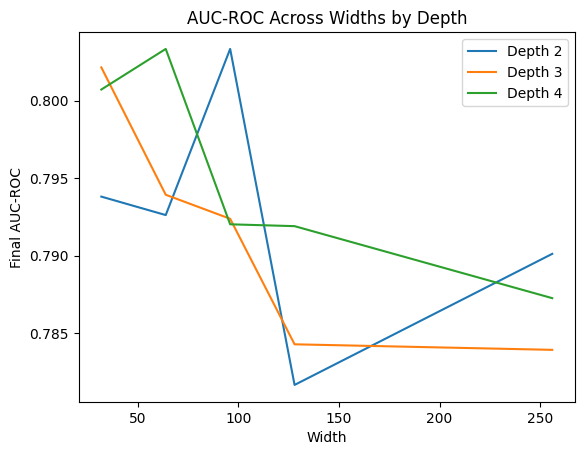

In [35]:
# Line plot for AUC-ROC across widths for each depth
for depth in results_df_with_weights['Depth'].unique():
    subset = results_df_with_weights[results_df_with_weights['Depth'] == depth]
    plt.plot(subset['Width'], subset['Final AUC-ROC'], label=f"Depth {depth}")
plt.title("AUC-ROC Across Widths by Depth")
plt.xlabel("Width")
plt.ylabel("Final AUC-ROC")
plt.legend()
plt.show()


# **Confusion matrix visualization and performance evaluation on the test dataset using the best-performing model architecture**

Training MLP: Depth=4, Width=64...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5318 - loss: 3.1514 - val_accuracy: 0.5550 - val_loss: 2.8628
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5010 - loss: 2.7971 - val_accuracy: 0.6450 - val_loss: 2.5323
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5739 - loss: 2.4783 - val_accuracy: 0.6300 - val_loss: 2.2498
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5713 - loss: 2.1995 - val_accuracy: 0.6550 - val_loss: 1.9972
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5822 - loss: 1.9670 - val_accuracy: 0.6350 - val_loss: 1.7927
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6032 - loss: 1.7546 - val_accuracy: 0.6900 - val_loss: 1.6050
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6767 - loss: 1.5715 - val_accuracy: 0.6800 - val_loss: 1.4390
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6713 - loss: 1.437

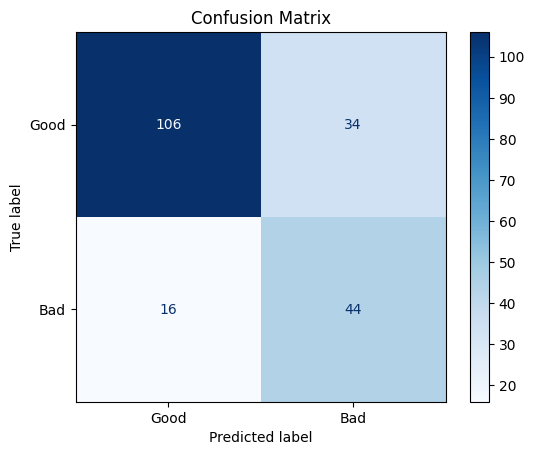

Classification Report:
               precision    recall  f1-score   support

        Good       0.87      0.76      0.81       140
         Bad       0.56      0.73      0.64        60

    accuracy                           0.75       200
   macro avg       0.72      0.75      0.72       200
weighted avg       0.78      0.75      0.76       200

AUC-ROC Score: 0.80
Model saved as 'best_mlp_model.keras'


In [45]:
# Using the best depth and width from experimentation
best_depth = 4
best_width = 64

# Train and evaluate the model with the best parameters
history, auc_score, classification_metrics = train_and_evaluate_with_class_weights(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    depth=best_depth,
    width=best_width,
    epochs=50,
    batch_size=32
)

# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot confusion matrix for the final model.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        labels: Class labels.
    """
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, cmap='Blues', normalize=None
    )
    plt.title("Confusion Matrix")
    plt.show()

# Predictions for the test set
y_pred_proba = history.model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['Good', 'Bad'])

# Print classification report and AUC score
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

# Calculate AUC-ROC score and round it to 2 decimal places
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Save the final model in the recommended Keras format
history.model.save("best_mlp_model.keras")
print("Model saved as 'best_mlp_model.keras'")
